# Evaluating Earthquake Damage in Nepal 

## Executive Summary

The culminating task for the [Microsoft Professional Program in Data Science](https://academy.microsoft.com/en-us/professional-program/tracks/data-science/) was to use damage data from the 2015 Gorkha earthquake in Nepal to build a machine learning model that could predict the damage a building might experience in an earthquake.  While our data set is quite small and might not generalize to other locations very well, a more robust version of this model could be used by city planners or insurance companies in assessing the risk of an earthquake. 

This report will review data exploration that was done to examine the relationship between features that were available in the data using descriptive statstics and data visualization.  These finding lead us to know what to exclude from the model as well as suggested what would likely help us distinguish between the three damage classes. We will then review the models which were built for the problem, and discuss their criticisms. 

Our best models were able to achieve f1 micro scores of 0.703 on the test set hosted on DrivenData, and was an ensamble of two logistic regression models, two random forests, and a neural network. After modeling, we were also interested in applying the permutation importance method as a way to interpret the model and how it used the features. 

From our data exploration and permutaion importance analysis we found that these features were important parts of the prediction:

  * geo_level_id_1 and 2: Certain areas were more likely to have greater amounts of damage.
  * age: Older buildings experienced more damage.
  * area: Buildings with more area tended to sustain less damage.
  * height: Taller building were at risk for more damage. 
  * superstructure: corrlated with higher (adobe, stone) or lower (cement/rc) damage grades
 
Finally, since this report is developed in Jupyter we will use Python to display some of the information and visuals throughout.  However, it is not the notebook where the model was original developed.  To review a notebook of the more technical model building process and to see some of the raw results, you can go to [my repository on GitHub.](https://github.com/mrklees/Data-Science-Capstone/blob/master/Earthquake%20Damage%20Model.ipynb)

## Exploring the Available Data

The entire game of modeling is based on the idea that there is information hidden in our data, and that these patterns can be figured out.  However when we are given a number of different variables, a first important task is get a sense of which variables might have the most information about how to distinguish between the target classes.  To this end data visualization is a very helpful tool in identifying which variables have the most visible trends with our target.

In [31]:
# These are our main data structures
import pandas as pd
import numpy as np

# These packages are used for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Training examples and labels are already split for us.  A quick check of the building_id variables
# confirms that they are ordered the same
data = pd.read_csv("data/train_values.csv")
labels = pd.read_csv("data/train_labels.csv")

# We'll merge the dataset for come convenience when visualizing
merged = data.merge(labels)

# The Submission Data 
test = pd.read_csv("data/test_values.csv")

With the data loaded, we can view some quick and basic information about our data.

In [32]:
print(f"The training data set has {merged.shape[0]} records and {merged.shape[1]} columns")
print("Descriptive stats are easily available for numeric variables.")
merged.describe().T

The training data set has 10000 records and 40 columns
Descriptive stats are easily available for numeric variables.


,count,mean,std,min,25%,50%,75%,max
building_id,10000.0,9987.1600,5800.800829,1.0,4998.75,9963.5,15044.75,19999.0
geo_level_1_id,10000.0,7.1356,6.225567,0.0,2.00,6.0,10.00,30.0
geo_level_2_id,10000.0,296.9303,279.390651,0.0,60.00,219.0,466.00,1411.0
geo_level_3_id,10000.0,2678.6179,2520.663769,0.0,606.75,1937.5,4158.00,12151.0
count_floors_pre_eq,10000.0,2.1467,0.736365,1.0,2.00,2.0,3.00,9.0
age,10000.0,25.3935,64.482893,0.0,10.00,15.0,30.00,995.0
area,10000.0,38.4381,21.265883,6.0,26.00,34.0,44.00,425.0
height,10000.0,4.6531,1.792842,1.0,4.00,5.0,5.00,30.0
has_superstructure_adobe_mud,10000.0,0.0897,0.285766,0.0,0.00,0.0,0.00,1.0
has_superstructure_mud_mortar_stone,10000.0,0.7626,0.425511,0.0,1.00,1.0,1.00,1.0


### Exploring the Distributions of Each Variable

It can be extremely valuable to study the distributions of each variable and compare pairs of variables.  This practice can help us identify which features are sneaking the most noise into our model, and how variables are effecting each other in isolation. Through visualization or some calculation, we explore each of the following questions:

  1. What are the distributions of each variable?
  2. How are the feature correllated with each other?
  3. How are the features correllated with the response variable?
  
#### What are the distributions of each variable?

To visualize the distributions of each variable in our dataset, we have created the histograms below.

	 	count_floors_pre_eq


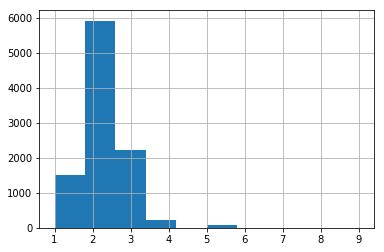

	 	age


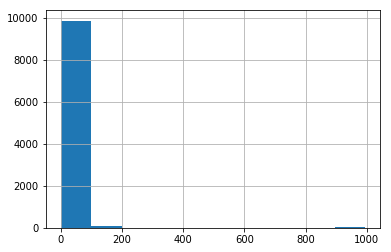

	 	area


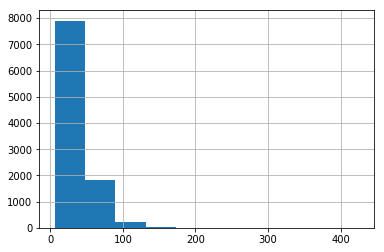

	 	height


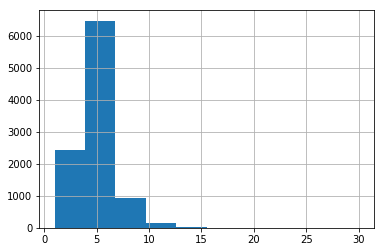

	 	land_surface_condition


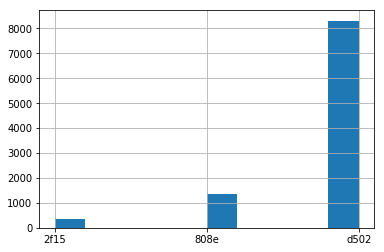

	 	foundation_type


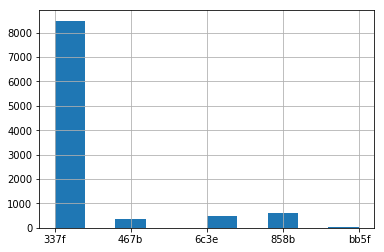

	 	roof_type


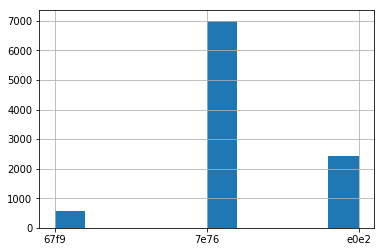

	 	ground_floor_type


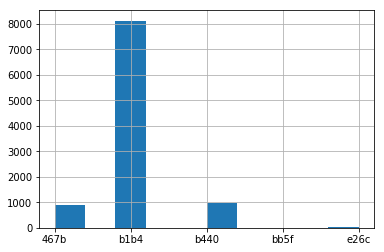

	 	other_floor_type


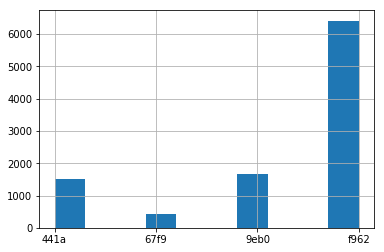

	 	position


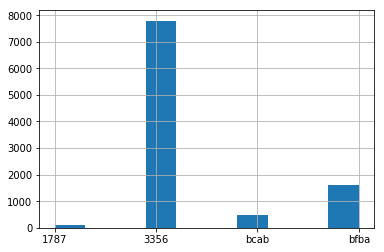

	 	plan_configuration


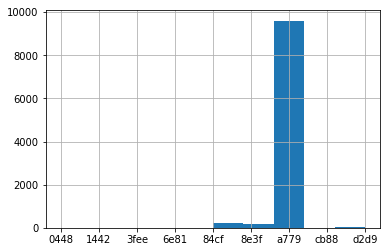

	 	legal_ownership_status


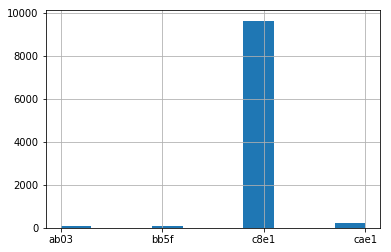

	 	count_families


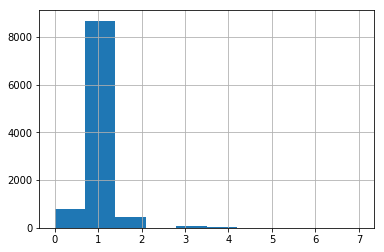

	 	damage_grade


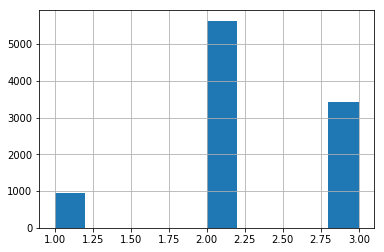

In [33]:
cols = ['count_floors_pre_eq', 'age', 'area', 'height',
       'land_surface_condition', 'foundation_type', 'roof_type',
       'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration','legal_ownership_status', 'count_families','damage_grade']

for col in cols:
    print("==========================================================")
    print(f"\t \t{col}")
    merged[col].hist()
    plt.show()

#### How are the features correllated with each other?

For numeric variables, we can easily visualize across their relationships with a scatter matrix.  For the rest, we'll calcualte a common statistic called the pearson correlation, which is explained further below.

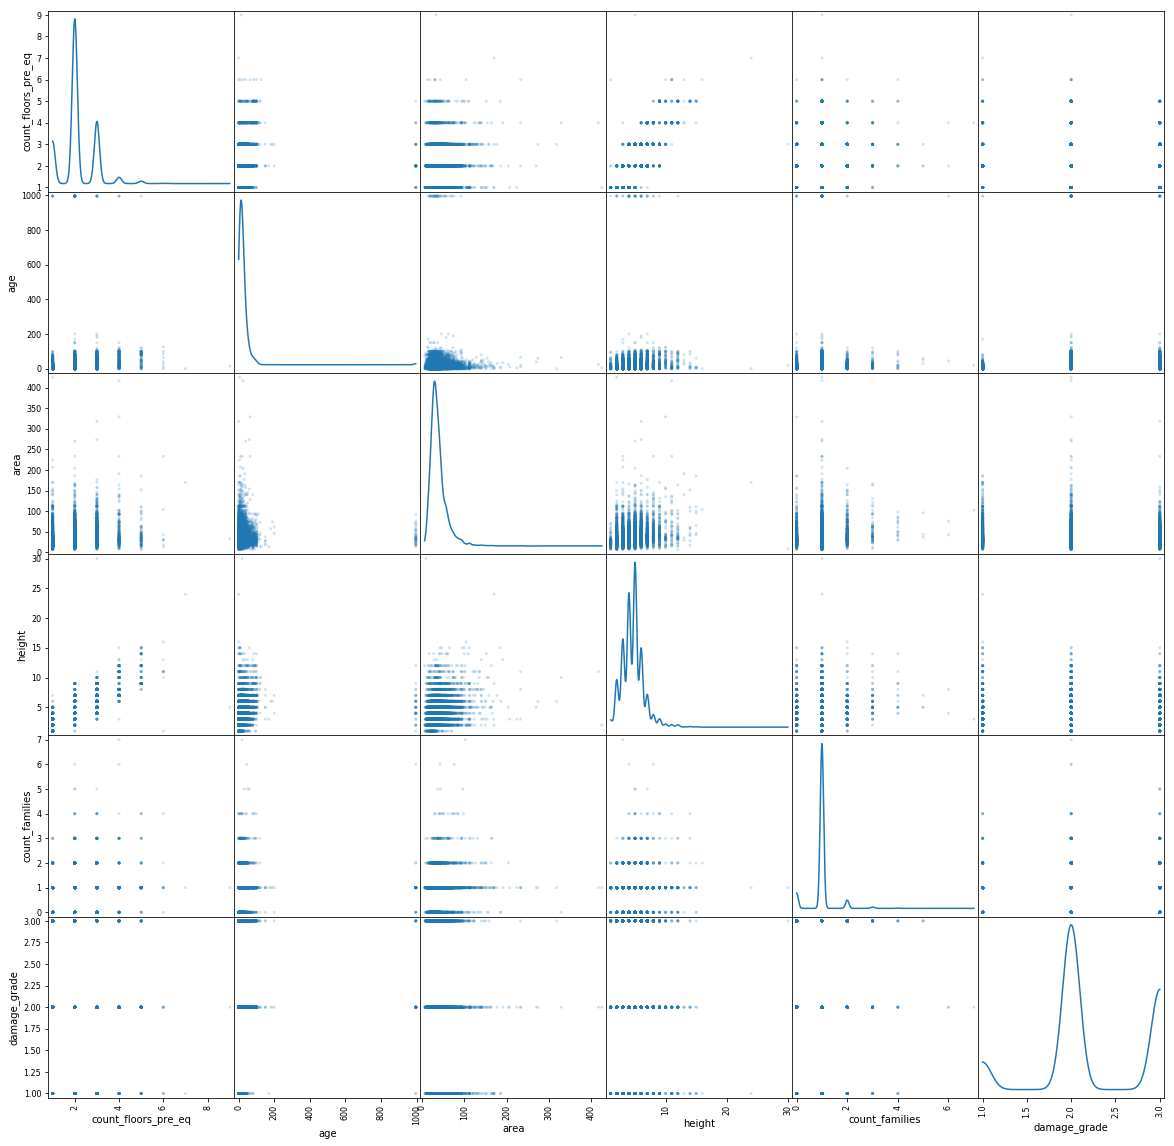

In [34]:
from pandas.plotting import scatter_matrix

scatter_matrix(merged[cols], alpha=0.2, figsize=(20, 20), diagonal='kde')
plt.show()

##### Correlation

The pearson correlation coefficient is an effective way of seeing if two pairs of variables correllated in a particular period.  Below we display the correlation matrix for all variables in a headmap.  A few things to notice, that certain super structures seem to be highly corrlated with higher (adobe, stone) or lower (cement/rc) damage grades.  Area also is clearly negative and floor count is clearly positive.  It's important not to overstate the value pearson correlation, but it does give us some hints.

Features With Associated Correlation in Increasing Order
has_superstructure_cement_mortar_brick   -0.233398
has_superstructure_rc_engineered         -0.179761
has_superstructure_rc_non_engineered     -0.156371
area                                     -0.114775
has_secondary_use                        -0.087286
has_secondary_use_hotel                  -0.085269
has_superstructure_timber                -0.080558
has_superstructure_cement_mortar_stone   -0.073337
has_superstructure_bamboo                -0.072327
geo_level_1_id                           -0.064084
has_secondary_use_rental                 -0.063367
has_secondary_use_school                 -0.041652
has_secondary_use_other                  -0.031927
has_secondary_use_institution            -0.029296
has_superstructure_other                 -0.019515
has_secondary_use_gov_office             -0.017306
has_secondary_use_agriculture            -0.013333
has_secondary_use_industry               -0.011504
building_id              

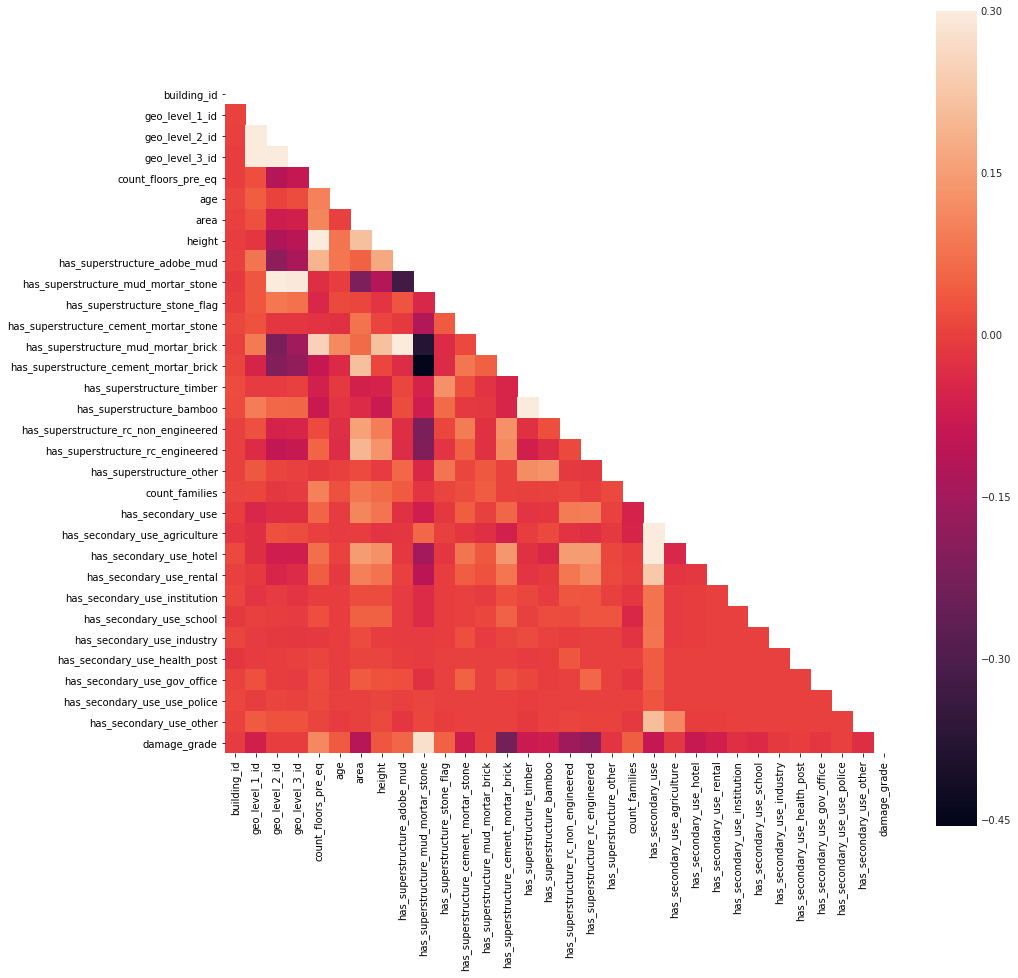

In [35]:
f, axs = plt.subplots(1, figsize=(15, 15))
cor = merged.corr()
print("Features With Associated Correlation in Increasing Order")
print(cor['damage_grade'].sort_values())
mask = np.zeros_like(cor)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(cor, mask=mask, vmax=.3, square=True, ax=axs)
plt.show()

### Cross Variable Comparisons

Since our response variable is categorical, and guided by some of the exploration above, we wanted to focus in on a few features in particular and see how informative they might be in helping us distringuish between the different damage grades.  From the four factor plots below we notice the following things:

  *  Along each of the variables, the difference between damage grades 1 versus 2 and 3 is usuall quite pronounced. 
  *  Conversly, damage grades 2 and 3 tend to overlap, particularly in age and height.
  *  We observe area's inverse relationship with damage grade

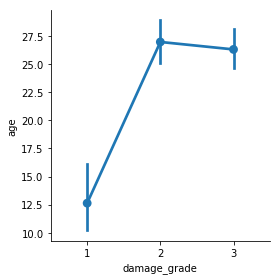

In [36]:
# How does Building Age correspond to damage grade?
sns.factorplot(x="damage_grade", y="age", data=merged)
# Observe that the average age for 1st grade damage was significantly lower than 2's and 3's. 

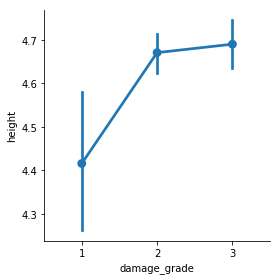

In [37]:
# Building Height versus Damage Grade
sns.factorplot(x="damage_grade", y="height", data=merged)
# Building height for grade 1's was slightly lower, though perhaps not significantly different 
# from 2's and 3's.  Maybe 2's and 3's contain more outliers though.

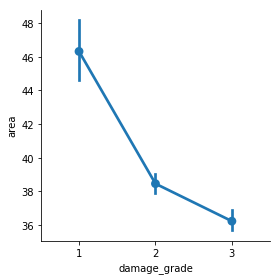

In [38]:
# Building Area versus Damage Grade
sns.factorplot(x="damage_grade", y="area", data=merged)

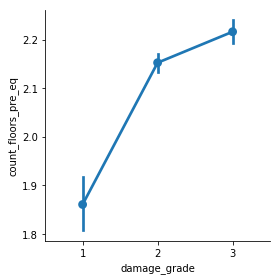

In [39]:
# Building Area versus Damage Grade
sns.factorplot(x="damage_grade", y="count_floors_pre_eq", data=merged)
# We notice that lower damage grades seem to correspond to

## Data Preparation

The final phases of data preparation were to put the data into [Feature Tools.](https://www.featuretools.com/)  It's a great tool for ensuring your data is clean, and also has a lot of support for automated feature engineering although we don't take advantage of that here.  Our primary goals were to ensure that:

  * Each column had the correct data type 
  * Categorical variables are one hot encoded
  * All columns are normalized
  * Dropping features with no information value (building_id)

#### Addressing Class Imbalance Problem

We noticed in the data that there is a severe class imbalance problem.  Class 2 is easily the largest, follow by class 3 which is about 50% of class 2 and class 1 which is about 15% the size of class 2. There are a number of approaches to this problem to consider:

  1. Undersample
  2. Oversample
  3. Penalize weights
  
1 and 2 can be facilitated by the imbalance-learn python package, and weight penalization is natively supported by many scikit-learn models.  

If these three methods don't get us close enough, we could also try breaking up this problem.  That is, first trying to predict class 1's with one model, and then trying to differentiate class 2 and 3's with a second.  I am often of the opinion that is better to try to get a single model to learn those more complex relationships, but so far that doesn't seem to be happening.

In [40]:
import featuretools as ft

def build_es(data):
    # Feature tools will do its best auto detect the dtypes of our variables.  However we'll need to make some corrections.
    dtypes = {
        'geo_level_1_id': ft.variable_types.Categorical,
        'geo_level_2_id': ft.variable_types.Categorical,
        'geo_level_3_id': ft.variable_types.Numeric,
        'has_superstructure_adobe_mud': ft.variable_types.Boolean,
        'has_superstructure_mud_mortar_stone': ft.variable_types.Boolean, 
        'has_superstructure_stone_flag': ft.variable_types.Boolean,
        'has_superstructure_cement_mortar_stone': ft.variable_types.Boolean,
        'has_superstructure_mud_mortar_brick': ft.variable_types.Boolean,
        'has_superstructure_cement_mortar_brick': ft.variable_types.Boolean, 
        'has_superstructure_timber': ft.variable_types.Boolean,
        'has_superstructure_bamboo': ft.variable_types.Boolean, 
        'has_superstructure_rc_non_engineered': ft.variable_types.Boolean,
        'has_superstructure_rc_engineered': ft.variable_types.Boolean, 
        'has_superstructure_other': ft.variable_types.Boolean,
        'has_secondary_use': ft.variable_types.Boolean,
        'has_secondary_use_agriculture': ft.variable_types.Boolean, 
        'has_secondary_use_hotel': ft.variable_types.Boolean,
        'has_secondary_use_rental': ft.variable_types.Boolean,
        'has_secondary_use_institution': ft.variable_types.Boolean,
        'has_secondary_use_school': ft.variable_types.Boolean, 
        'has_secondary_use_industry': ft.variable_types.Boolean,
        'has_secondary_use_health_post': ft.variable_types.Boolean, 
        'has_secondary_use_gov_office': ft.variable_types.Boolean,
        'has_secondary_use_use_police': ft.variable_types.Boolean, 
        'has_secondary_use_other': ft.variable_types.Boolean
    }
    
    # Start be definng an EntitySet.  This abstractly contains all data we'll use to train the model, potentially in multiple tables. 
    es = ft.EntitySet(id="Buildings")

    data = data.copy()
    data.reset_index(inplace=True)
    # With the container defined, we'll add our data
    es = es.entity_from_dataframe(entity_id='buildings',
                                  dataframe=data,
                                  variable_types=dtypes,
                                  index="index")

    # This method will traverse our categorical variables and identify interesting values to construct
    # where variables from
    es.add_interesting_values(max_values=50, verbose=False)

    return es

es = build_es(data)

# Yields our base feature matrix and defs
base_mat, base_defs = ft.dfs(entityset=es,
                               target_entity='buildings',
                               agg_primitives=[],
                               max_depth=2)

# Encode categorical features with one hot encoding using feature tools
basemat_encoded, base_encoded = ft.encode_features(base_mat, base_defs, include_unknown=False, top_n=1000,
                                                   to_encode=['geo_level_1_id', 'geo_level_2_id', 
                                                              'land_surface_condition', 'foundation_type',
                                                              'roof_type', 'ground_floor_type', 'other_floor_type',
                                                              'position', 'plan_configuration', 'legal_ownership_status'])
# Save the feature sets so that we can load them with our submission data
ft.save_features(base_encoded, "base_features")

base = basemat_encoded.drop(['building_id'], axis=1)

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV

def preprocessing(X, y=None):
    # At this point, any NA's can just be filled with 0.  
    X.fillna(0, inplace=True)
    # Drop columns which have no information value
    # X = drop_unused(X)
    # Drop any columns which only have a single value
    #X = drop_trivial(X)
    # Scale our numeric cols
    X = norm_cols(X)
    return X, y

def drop_trivial(data):
    """If a column only has 1 value, drop it"""
    for col in data.columns:
        if len(data[col].unique()) == 1:
            data.drop(col,inplace=True,axis=1)            
    return data

def norm_cols(data):
    # Identify columns in need of scaling by those who have more than two values
    numeric = list(data.loc[:, (data.apply(lambda x: len(x.unique())) > 2).values].columns)
    #numeric.remove('geo_level_3_id')
    scaler = RobustScaler()
    scaled = pd.DataFrame(scaler.fit_transform(data[numeric]), columns=numeric)
    for column in numeric:
        data[column] = scaled[column]
    return data

In [41]:
# Obtain our preprocessed data and split it into training and validations sets
X, y = preprocessing(base, labels.damage_grade)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, stratify=y)

C:\Users\perus\AppData\Local\Continuum\Anaconda3\envs\bayes\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## Statistical Modeling

Our primary strategy when modeling this problem was to try different types of models and then potentially combine them.  After much tinkering we landed on using 5 main models and then combined them into a voting classifier.  These models were a logistic regression classifier, another logistic classifier but with the SMOTE oversampling method in conjunction, a random forest, a random forest with class weighting applied, and finally a fully conected neural network. 

As each model was built, it was evaluated with cross validation over a training set and then evaluated on a validation set with the f1 metric to best match the evaluator on the leaderboard.  Here is an example of these with the first logistic model trained.  For brevity, the remainder of the detail on each model is contained in the [model report on GitHub.](https://github.com/mrklees/Data-Science-Capstone/blob/master/Earthquake%20Damage%20Model.ipynb)

However, here were the results from the classification reports from each of our models:

| Model | f1 micro on 25-fold Cross Validation | Precision on Test Data | Recall on Test Data | f1 micro on test |
|:-----:|:----------------------------:|:----------------------:|:-------------------:|:----------------:|
| Logistic Regression | .669 | 0.67 | 0.67 | 0.66 |
| Logistic Regression w/ Oversampling | 0.63 | 0.65 | 0.59 | 0.59 |
| Random Forest | 0.683 | 0.68 | 0.68 | 0.66 |
| Random Forest w/ Class Weighting | 0.643 | 0.66 | 0.66 | 0.66 | 
| Neural Network | - | 0.65 | 0.65 | 0.6376
| Voting Classifier | 0.693 | 0.7 | 0.7 | 0.7 |

In [46]:
# Since we are being score on f1_score, we'll use this as our main measure of model fit
from sklearn.metrics import f1_score, classification_report
# This filter method will help when we have a lot of features.  We will also want to try
# PCA or some other form of dimensionality reduction as well. 
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import SGDClassifier

def cross_validate(model, X, y, n_folds=5, oversample=False):       
    skf = StratifiedKFold(n_folds)
    training_scores = []
    validation_scores = []
    
    for ts, vs in skf.split(X, y):
        xt, yt = X[ts, :], y.reshape(-1, 1)[ts, :]
        xv, yv = X[vs, :], y.reshape(-1, 1)[vs, :]
        if oversample:
            xt, yt = SMOTE(n_jobs=-1).fit_sample(xt, yt)
        model.fit(xt, yt)
        training_scores.append(score_model(model, xt, yt))
        val_score = score_model(model, xv, yv)
        print(val_score)
        validation_scores.append(val_score)
    training_scores = np.array(training_scores)
    validation_scores = np.array(validation_scores)
    print(f"Training Error was distributed with mean:{training_scores.mean()}, std: {training_scores.std()}")
    print(f"Validation Error was distributed with mean:{validation_scores.mean()}, std: {validation_scores.std()}")  

def make_predictions(model, X, y):
    testing = X.copy()
    testing['preds'] = model.predict(X)
    testing['actual'] = y.values
    testing['correct'] = np.where(testing.preds == testing.actual, 1, 0)
    return testing
    
def plot_error_by_class(model, X, y):
    testing = make_predictions(model, X, y)

    # Our accuracy for each class
    # Clearly the class imbalance problem 
    sns.factorplot(x="actual", y='correct', data=testing)
    plt.show()
    
def score_model(model, X, y):
    return model.score(X, y)

In [53]:
selector = SelectKBest(k='all')
Xfiltered = pd.DataFrame(selector.fit_transform(X_train, y_train))
logit_model = SGDClassifier(loss='log', penalty='elasticnet', max_iter=1000000, tol=1e-12, alpha=0.0001, l1_ratio=0.55)
cross_validate(logit_model, Xfiltered.values, y_train.values, n_folds=5, oversample=False)

C:\Users\perus\AppData\Local\Continuum\Anaconda3\envs\bayes\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 810  872  949  968  976  987 1028 1029 1034 1046 1050 1056 1066 1067
 1069 1072] are constant.
  UserWarning)
C:\Users\perus\AppData\Local\Continuum\Anaconda3\envs\bayes\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6537949400798935
0.6524633821571239
0.6711051930758988
0.6631158455392809
0.6826666666666666
0.6773333333333333
0.6973333333333334
0.7022696929238985
0.6421895861148198
0.6644385026737968
Training Error was distributed with mean:0.7227989931113827, std: 0.013926921899655428
Validation Error was distributed with mean:0.6706710475898044, std: 0.01849665565930226


In [48]:
# Apply KBest to validation dataset
X_test_filtered = pd.DataFrame(selector.transform(X_test))
# Train model on all data
logit_model.fit(Xfiltered.values, y_train.values)
target_names = ['Damage Grade 1', 'Damage Grade 2', 'Damage Grade 3']
print(classification_report(y_test, logit_model.predict(X_test), target_names=target_names))

                precision    recall  f1-score   support

Damage Grade 1       0.49      0.48      0.49       234
Damage Grade 2       0.70      0.76      0.72      1409
Damage Grade 3       0.66      0.57      0.61       857

   avg / total       0.66      0.67      0.66      2500



As we can see in the classification report, due to the class imbalance problem our model will predictably have trouble to the less popular classes.  Grade 2's, the most common grade, is identified correctly the most frequently.  However, grade 1's and 3's do signifciantly worse.  As we developed different models, we also tracked its results for each damage grade with the visualization below:

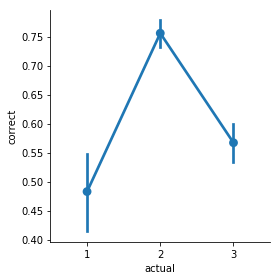

In [49]:
plot_error_by_class(logit_model, X_test_filtered, y_test)

# Conclusion

This data was sufficient for us to build a model with a f1-score of 0.7, and while that's certainly better than a coin-flip our model is still quite uncertain in its predictions.  Let's consider what some limitations were in the data that prevented us from a more accurate answer.

## Limitations of the Model, e.g. Limitations of the Data

### Class imbalance problem was a significant challenge

We were limited in our accuracy by the class imablance, and in a buisiness case we would likely pursue collecting more examples of graded 1 and 3 building damage.  We did attempt to control for the inbalance through the classical approaches of oversampling, undersampling, and class weighting.  However each of the approaches led to a decrease in accuracy as these model's ability to predict grade 2 building degraded signficantly.  One advantage of the voting classifier we used was that it was able to incorporate predictions from both models with oversampling and class weighting, and from models without it. 

### Geographic location was hidden

We were given geographic ids at three different scales as a way to consider how a buildings neighbors had done when considering it's level of damage.  We wonder if given latitutde and longitude or someother location measurement with a more objective frame of reference if we might have been able to exploit the physical patterns of earthquakes more effectively.  Moreover, this feature really prevents us from generalizing this model, as the geo codes as specific to this dataset. 

### Damage as a classification task

This task is a curious one posed as a classification task, and perhaps should actually be framed as a regression  problem.  One reason why this might help was because of the challenge in distinguishing between grade 2 and grade 3 damage. In fact, based on the limitations of all of the models on the leaderboard (at last check not a single entry with f1_micro > 0.72), we might wonder how much overlap there is between grades 2 and 3 levels of damage.  By overlap I actually mean, given two houses with precisely the same parameters, what might be the probability that their outcomes are different (one is grade 2 and the other is grade 3) due to pure random chance.  With this thought in mind, it might be better to predict the cost of the damage as a real value to allow for more nuance.

## A Pathway to Production

Suppose that this report represented an exploratory pilot of the problem and that our organization, perhaps an insurance company, is sufficiently convinced that the problem is modelable.  What would be our next steps? 

A first step would definitely be to invest in data collection.  Data from a single earthquake in a single region is insufficient to generalize to the problem of all buildings everywhere.  So we would want to source or collect data from other earthquakes and build up a large database.  Some of the features would need changing as well.  Geographic data seems really important in this model, and yet we weren't given absolute measurements of location.  Something like lat/long would be more generalizable. Finally, we would want to make some determination about our needs from this model.  Determinations like how accurate do we need the model to be to be confident in our decision making?  Do we care about predicting one class over the others?  For example, if we're an insurance company than predicting grade 3 damage would be really important, because that's where we'll lose the most money.  These questions would need be to refined in faciliated conversations with stakeholders, before being built into the final model.

Thanks for your attention in going through this report!